## MACD strategy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

In [2]:
path = "data/round_1"


def get_prices(round: int, day: int):

    path = f"data/round_{round}/prices_round_{round}_day_{day}.csv"

    return pd.read_csv(path, sep=";")


def get_trades(round: int, day: int):

    path = f"data/round_{round}/trades_round_{round}_day_{day}.csv"

    return pd.read_csv(path, sep=";")

prices = get_prices(1, -2)
trades = get_trades(1, -1)

def calculate_MACD(
    data: pd.DataFrame,
    price_col: str,
    short_window: int,
    long_window: int,
    smoothing_window: int,
    min_periods: int,
):

    # Calculate the 12-period EMA

    ema_short = data[price_col].ewm(span=short_window, adjust=False).mean()

    ema_long = data[price_col].ewm(span=long_window, adjust=False).mean()

    macd = ema_short - ema_long

    signal = macd.ewm(span=smoothing_window, adjust=False).mean()

    macd.iloc[:min_periods] = np.nan

    signal.iloc[:min_periods] = np.nan

    return macd, signal, ema_short, ema_long



def plot_MACD(prices: pd.DataFrame, macd, signal, ema_short, ema_long):
    fig = plt.figure(figsize=(25, 10))

    gs = GridSpec(2, 1, height_ratios=[2, 1.5], figure=fig)

    price_ax = plt.subplot(gs[0])

    macd_ax = plt.subplot(gs[1])

    price_ax.plot(prices["timestamp"], prices["mid_price"])
    price_ax.plot(prices["timestamp"], ema_short, label="Short EMA", color="green")
    price_ax.plot(prices["timestamp"], ema_long, label="Long EMA", color="red")
    price_ax.legend()

    macd_ax.plot(macd, color="red", label="MACD")
    macd_ax.plot(signal, color="green", label="Signal")
    macd_ax.legend()

    plt.show()

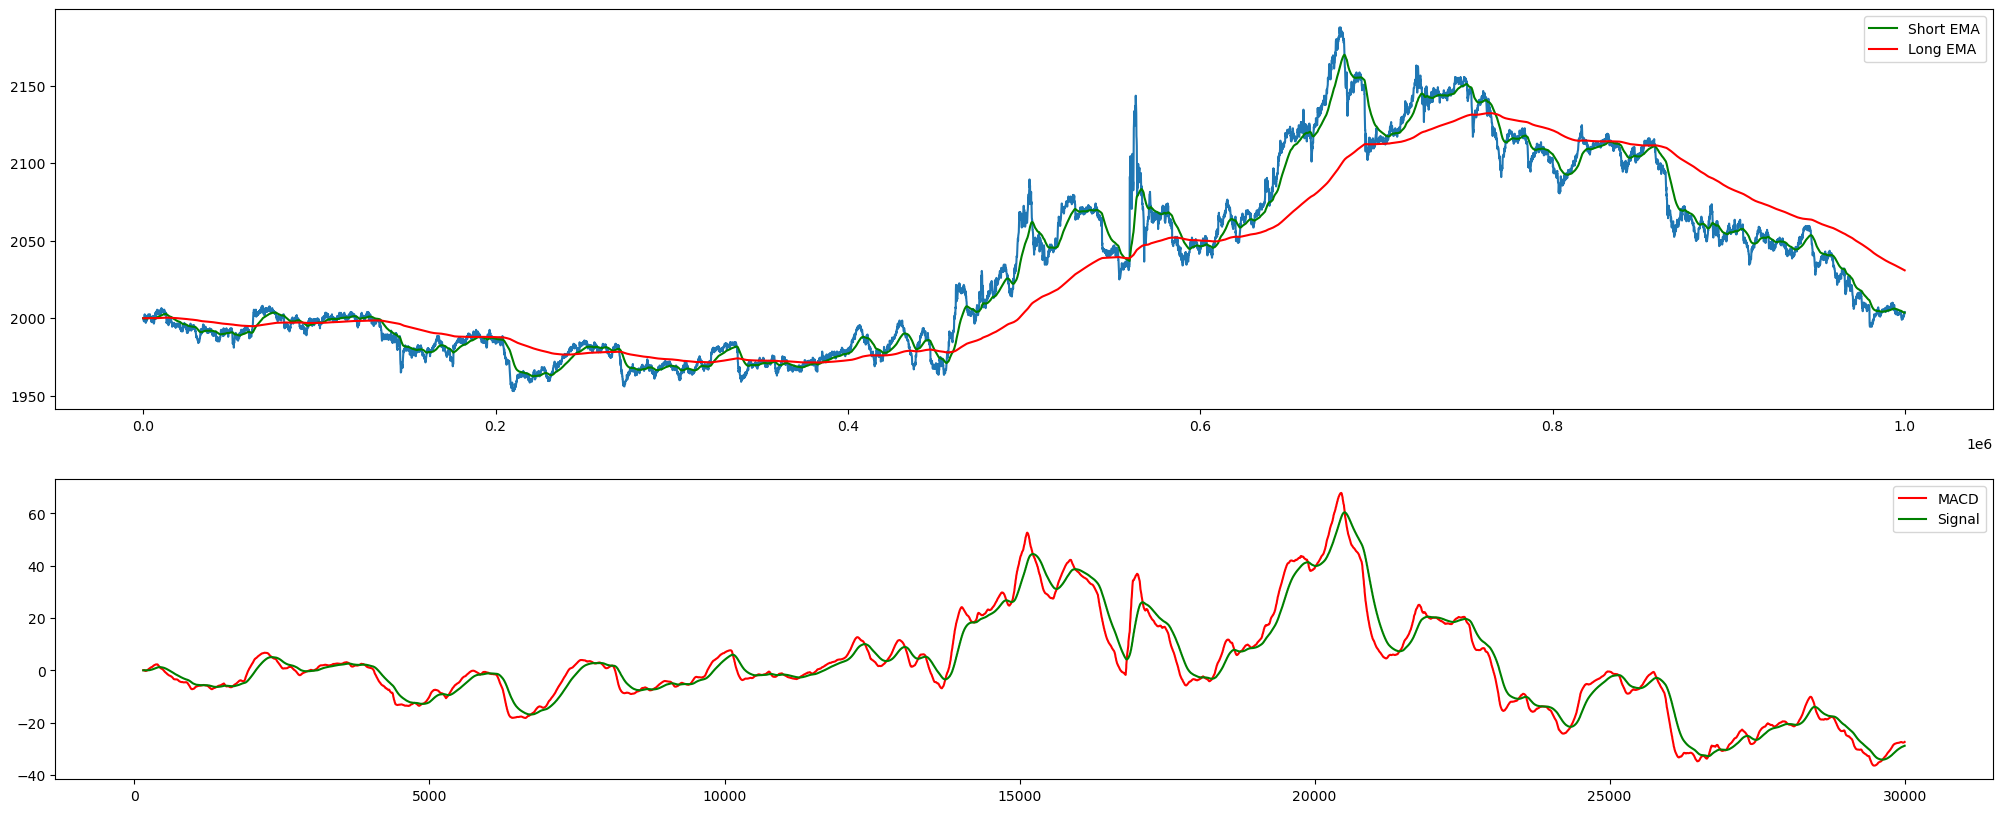

In [3]:
prices.sort_values(["product", "timestamp"], inplace=True)
SQUID_INK = prices[prices["product"] == "SQUID_INK"].sort_values("timestamp")

SHORT_WINDOW = 100
LONG_WINDOW = 1000
SMOOTHING_WINDOW = 100

macd, signal, ema_short, ema_long = calculate_MACD(
    SQUID_INK, "mid_price", SHORT_WINDOW, LONG_WINDOW, SMOOTHING_WINDOW, 50
)

plot_MACD(SQUID_INK, macd, signal, ema_short, ema_long)

In [4]:
SQUID_INK["long"] = ema_short > ema_long
SQUID_INK["ret"] = SQUID_INK["mid_price"].pct_change()
SQUID_INK["long_ret"] = np.where(SQUID_INK["long"].shift(1), SQUID_INK["ret"] + 1, 1)

SQUID_INK.tail(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,long,ret,long_ret
29970,-2,999000,SQUID_INK,1999,31,NaN,NaN,NaN,NaN,2002,29,NaN,NaN,NaN,NaN,2000.5,0.0,False,-0.000500,1.0
29975,-2,999100,SQUID_INK,1999,28,NaN,NaN,NaN,NaN,2002,28,NaN,NaN,NaN,NaN,2000.5,0.0,False,0.000000,1.0
29978,-2,999200,SQUID_INK,2000,31,NaN,NaN,NaN,NaN,2003,31,NaN,NaN,NaN,NaN,2001.5,0.0,False,0.000500,1.0
29980,-2,999300,SQUID_INK,2000,31,NaN,NaN,NaN,NaN,2002,8,2003.0,31.0,NaN,NaN,2001.0,0.0,False,-0.000250,1.0
29982,-2,999400,SQUID_INK,2001,1,2000.0,24.0,NaN,NaN,2004,24,NaN,NaN,NaN,NaN,2002.5,0.0,False,0.000750,1.0
29986,-2,999500,SQUID_INK,2000,26,NaN,NaN,NaN,NaN,2003,26,NaN,NaN,NaN,NaN,2001.5,0.0,False,-0.000499,1.0
29990,-2,999600,SQUID_INK,2001,30,NaN,NaN,NaN,NaN,2004,30,NaN,NaN,NaN,NaN,2002.5,0.0,False,0.000500,1.0
29992,-2,999700,SQUID_INK,2001,22,NaN,NaN,NaN,NaN,2005,22,NaN,NaN,NaN,NaN,2003.0,0.0,False,0.000250,1.0
29994,-2,999800,SQUID_INK,2002,26,NaN,NaN,NaN,NaN,2004,3,2005.0,26.0,NaN,NaN,2003.0,0.0,False,0.000000,1.0
29999,-2,999900,SQUID_INK,2003,4,2002.0,32.0,NaN,NaN,2005,32,NaN,NaN,NaN,NaN,2004.0,0.0,False,0.000499,1.0


In [5]:
entry_points = SQUID_INK["long"] != SQUID_INK["long"].shift(1)
SQUID_INK["is_entry_point"] = np.all(
    [SQUID_INK["long"] == True, SQUID_INK["long"].shift(1) == False], axis=0
)
SQUID_INK["is_exit_point"] = np.all(
    [SQUID_INK["long"] == False, SQUID_INK["long"].shift(1) == True], axis=0
)

SQUID_INK.tail(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,long,ret,long_ret,is_entry_point,is_exit_point
29970,-2,999000,SQUID_INK,1999,31,NaN,NaN,NaN,NaN,2002,...,NaN,NaN,NaN,2000.5,0.0,False,-0.000500,1.0,False,False
29975,-2,999100,SQUID_INK,1999,28,NaN,NaN,NaN,NaN,2002,...,NaN,NaN,NaN,2000.5,0.0,False,0.000000,1.0,False,False
29978,-2,999200,SQUID_INK,2000,31,NaN,NaN,NaN,NaN,2003,...,NaN,NaN,NaN,2001.5,0.0,False,0.000500,1.0,False,False
29980,-2,999300,SQUID_INK,2000,31,NaN,NaN,NaN,NaN,2002,...,31.0,NaN,NaN,2001.0,0.0,False,-0.000250,1.0,False,False
29982,-2,999400,SQUID_INK,2001,1,2000.0,24.0,NaN,NaN,2004,...,NaN,NaN,NaN,2002.5,0.0,False,0.000750,1.0,False,False
29986,-2,999500,SQUID_INK,2000,26,NaN,NaN,NaN,NaN,2003,...,NaN,NaN,NaN,2001.5,0.0,False,-0.000499,1.0,False,False
29990,-2,999600,SQUID_INK,2001,30,NaN,NaN,NaN,NaN,2004,...,NaN,NaN,NaN,2002.5,0.0,False,0.000500,1.0,False,False
29992,-2,999700,SQUID_INK,2001,22,NaN,NaN,NaN,NaN,2005,...,NaN,NaN,NaN,2003.0,0.0,False,0.000250,1.0,False,False
29994,-2,999800,SQUID_INK,2002,26,NaN,NaN,NaN,NaN,2004,...,26.0,NaN,NaN,2003.0,0.0,False,0.000000,1.0,False,False
29999,-2,999900,SQUID_INK,2003,4,2002.0,32.0,NaN,NaN,2005,...,NaN,NaN,NaN,2004.0,0.0,False,0.000499,1.0,False,False


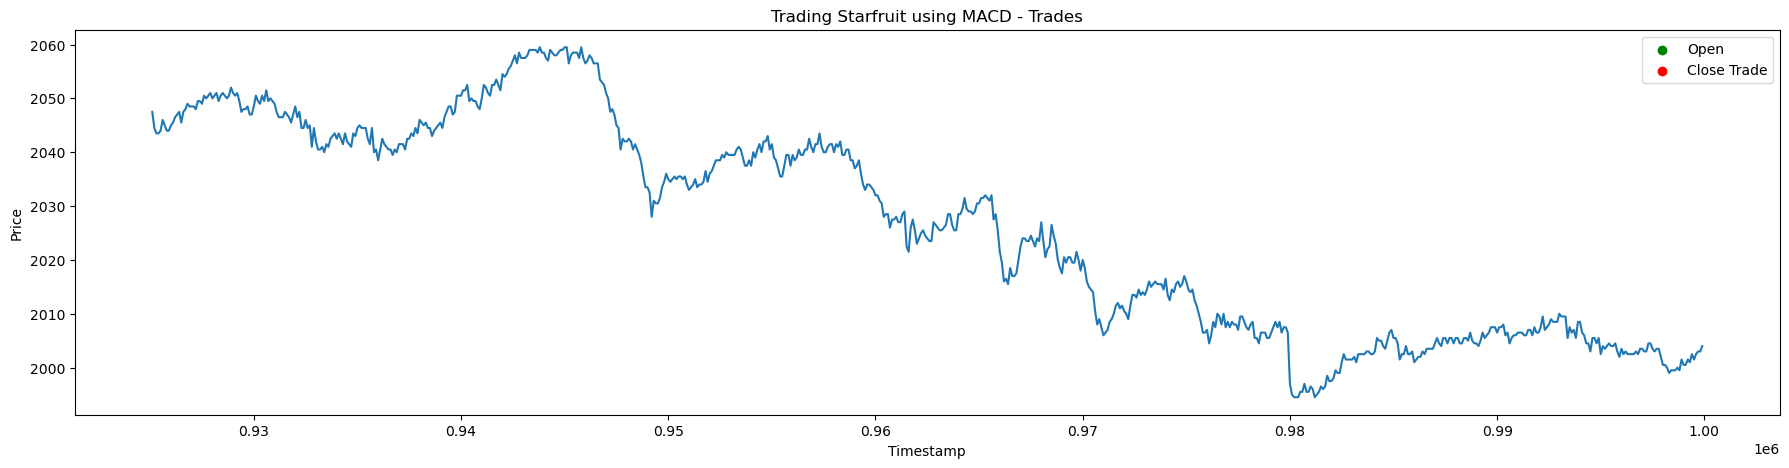

In [6]:
def plot_trades(data: pd.DataFrame, from_timestamp: int):
    fig, ax = plt.subplots(figsize=(22, 5))

    data = data[data["timestamp"] > from_timestamp].copy()

    ax.plot(data["timestamp"], data["mid_price"])

    entries = data[data["is_entry_point"]]
    exits = data[data["is_exit_point"]]

    for i, trade_series in enumerate([entries, exits]):
        color = "green" if i == 0 else "red"
        label = "Open" if i == 0 else "Close" + " Trade"
        ax.scatter(
            trade_series["timestamp"],
            trade_series["mid_price"],
            color=color,
            label=label,
            zorder=i + 2,
        )

    ax.legend()
    ax.set_title("Trading Starfruit using MACD - Trades")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")


plot_trades(SQUID_INK, 9.25e5)

Text(0, 0.5, 'Equity')

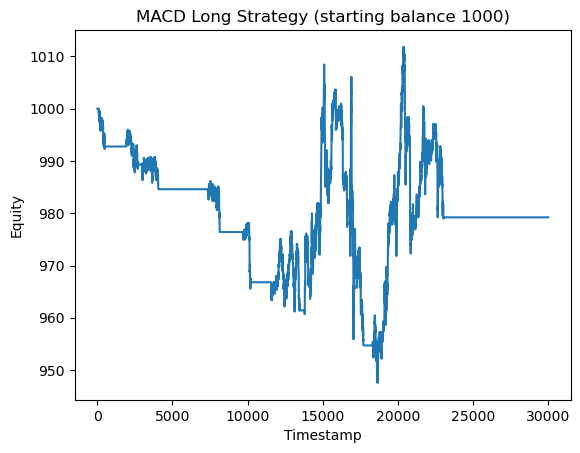

In [7]:
bal = 1000 * SQUID_INK["long_ret"].cumprod()

plt.plot(bal)
plt.title("MACD Long Strategy (starting balance 1000)")
plt.xlabel("Timestamp")
plt.ylabel("Equity")